In [25]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append('../..')
from nld_utils import simulate_lorenz
from utils import load

### 1) Initialize Parameters

In [20]:
T = 125 # s, duration of time series
dt = 0.02 # s, time step
D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter
# beta = 1e-4 # regularization parameter
sigma = 0.1 # maximum value of the input weights

squared_inds = None
# squared_inds = np.random.choice(np.arange(D_r), size=(int(D_r/2),), replace=False)

var_names = ['x', 'y', 'z']

# initial_condition = None 
# initial_condition = (-8, -7, 29)
initial_condition = (-8.01304744, -6.58865759, 28.60202532)

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [21]:
lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

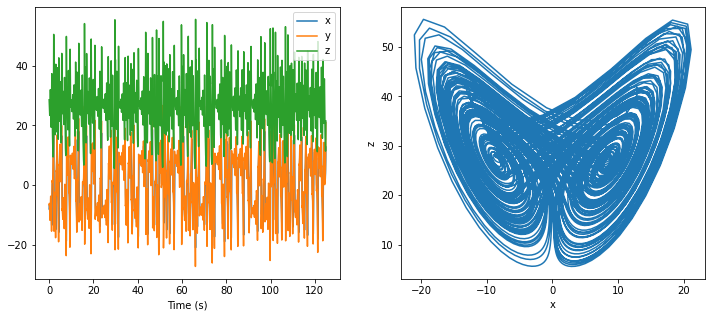

In [22]:
time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [23]:
reservoir = load("/Users/adameisen/Documents/MIT/2021 Summer/ChaoticConsciousness/__data__/reservoir 2021-06-09 14:15:39.pkl")

In [34]:
class ReservoirNet(torch.nn.Module):
    
    def __init__(self, reservoir):
        super(ReservoirNet, self).__init__()
        
        self.input_size = reservoir.D
        self.hidden_dim = reservoir.D_r
        self.output_size = reservoir.D
        self.n_layers = 1
        # RNN layer
        self.rnn = torch.nn.RNN(self.input_size, self.hidden_dim, self.n_layers, batch_first=True)
        # Fully connected layer
        self.fc = torch.nn.Linear(self.hidden_dim, self.output_size)
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [35]:
reservoirNet = ReservoirNet(reservoir)

In [37]:
reservoirNet(torch.from_numpy(reservoir.u[0].reshape(1, 1, -1)))

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat2' in call to _th_addmm_out